# Spectral Normalization with MNIST (or Fashion MNIST)

* `Spectral Normalization for Generative Adversarial Networks`, [arXiv:1802.05957](https://arxiv.org/abs/1802.05957)
  * Takeru Miyato, Toshiki Kataoka, Masanori Koyama, Yuichi Yoshida
  
* This code is available to tensorflow version 2.0
* Implemented by [`tf.keras.layers`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers) [`tf.losses`](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/losses)
* Use `transposed_conv2d` and `conv2d` for Generator and Discriminator, respectively.
  * I do not use `dense` layer for model architecture consistency. (So my architecture is different from original dcgan structure)
  
* This code refers to [TensorFlow official tutorial dcgan code](https://www.tensorflow.org/alpha/tutorials/generative/dcgan).

## 1. Import modules

In [1]:
import os
import sys
import time
import glob

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import PIL
import imageio
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers

os.environ["CUDA_VISIBLE_DEVICES"]="0"


## 2. Setting hyperparameters

In [2]:
# Training Flags (hyperparameter configuration)
model_name = 'spectral_norm'
train_dir = os.path.join('train', model_name, 'exp1')
dataset_name = 'mnist'
assert dataset_name in ['mnist', 'fashion_mnist']

max_epochs = 100
save_model_epochs = 10
print_steps = 200
save_images_epochs = 1
batch_size = 64
learning_rate_D = 2e-4
learning_rate_G = 2e-4
k = 5 # the number of step of learning D before learning G (Not used in this code)
num_examples_to_generate = 25
noise_dim = 100
MNIST_SIZE = 28

## 3. Load the MNIST dataset

In [3]:
# Load training and eval data from tf.keras
if dataset_name == 'mnist':
  (train_images, train_labels), _ = \
      tf.keras.datasets.mnist.load_data()
else:
  (train_images, train_labels), _ = \
      tf.keras.datasets.fashion_mnist.load_data()

train_images = train_images.reshape(-1, MNIST_SIZE, MNIST_SIZE, 1).astype('float32')
#train_images = train_images / 255. # Normalize the images to [0, 1]
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]


## 4. Set up dataset with `tf.data`

### create input pipeline with `tf.data.Dataset`

In [4]:
#tf.random.set_seed(219)
# for train
N = len(train_images)
train_dataset = tf.data.Dataset.from_tensor_slices(train_images)
train_dataset = train_dataset.shuffle(buffer_size=N)
train_dataset = train_dataset.batch(batch_size=batch_size, drop_remainder=True)
print(train_dataset)

<BatchDataset shapes: (64, 28, 28, 1), types: tf.float32>


2021-12-23 20:55:20.538325: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-12-23 20:55:21.037518: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 18516 MB memory:  -> device: 0, name: GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6


## 5. Create the generator and discriminator models

In [5]:
class ConvTranspose(tf.keras.Model):
  def __init__(self, filters, kernel_size, padding='same',
               apply_batchnorm=True, activation='relu'):
    super(ConvTranspose, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'sigmoid', 'tanh']
    self.activation = activation
    self.up_conv = layers.Conv2DTranspose(filters=filters,
                                          kernel_size=(kernel_size, kernel_size),
                                          strides=2,
                                          padding=padding,
                                          kernel_initializer=tf.random_normal_initializer(0., 0.02),
                                          use_bias=not self.apply_batchnorm)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()

  def call(self, x, training=True):
    # conv transpose
    x = self.up_conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
      
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'sigmoid':
      x = tf.nn.sigmoid(x)
    else:
      x = tf.nn.tanh(x)
    
    return x

In [6]:
class Generator(tf.keras.Model):
  """Build a generator that maps latent space to real space.
    G(z): z -> x
  """
  def __init__(self):
    super(Generator, self).__init__()
    self.conv1 = ConvTranspose(256, 3, padding='valid')
    self.conv2 = ConvTranspose(128, 3, padding='valid')
    self.conv3 = ConvTranspose(64, 4)
    self.conv4 = ConvTranspose(1, 4, apply_batchnorm=False, activation='tanh')

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [1, 1, 100]
    conv1 = self.conv1(inputs, training=training)           # conv1: [3, 3, 256]
    conv2 = self.conv2(conv1, training=training)            # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2, training=training)            # conv3: [14, 14, 64]
    generated_images = self.conv4(conv3, training=training) # generated_images: [28, 28, 1]
    
    return generated_images


In [11]:
class Conv(tf.keras.Model):
  def __init__(self, filters, kernel_size, strides, padding='same',
               apply_batchnorm=True, activation='relu', kernel_constraint=None):
    super(Conv, self).__init__()
    self.apply_batchnorm = apply_batchnorm
    assert activation in ['relu', 'leaky_relu', 'none']
    self.activation = activation
        
    self.conv = layers.Conv2D(filters=filters,
                              kernel_size=(kernel_size, kernel_size),
                              strides=strides,
                              padding=padding,
                              kernel_initializer=tf.random_normal_initializer(0., 0.02),
                              use_bias=not self.apply_batchnorm,
                              kernel_constraint=kernel_constraint)
    if self.apply_batchnorm:
      self.batchnorm = layers.BatchNormalization()
  
  def call(self, x, training=True):
    # convolution
    x = self.conv(x)
    
    # batchnorm
    if self.apply_batchnorm:
      x = self.batchnorm(x, training=training)
    
    # activation
    if self.activation == 'relu':
      x = tf.nn.relu(x)
    elif self.activation == 'leaky_relu':
      x = tf.nn.leaky_relu(x)
    else:
      pass
    
    return x

In [12]:
class SpectralNorm(tf.keras.constraints.Constraint):
    def __init__(self, iteration=1):
        self.iteration = iteration
    
    def __call__(self, w):
        
        w_reshaped = tf.reshape(w, [-1, w.shape[-1]])
        u_hat = tf.random.normal([1, w.shape[-1]])
        
        for _ in range(self.iteration):
            v_ = u_hat @ tf.transpose(w_reshaped)
            v_hat = tf.nn.l2_normalize(v_)
            
            u_ = v_hat @ w_reshaped
            u_hat = tf.nn.l2_normalize(u_)
        
        sigma = v_hat @ w_reshaped @ tf.transpose(u_hat)
        w_norm = w / sigma
        
        return w_norm

In [13]:
class Discriminator(tf.keras.Model):
  """Build a discriminator that discriminate real image x whether real or fake.
    D(x): x -> [0, 1]
  """
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = Conv(64, 4, 2, apply_batchnorm=False, activation='leaky_relu', kernel_constraint=SpectralNorm())
    self.conv2 = Conv(128, 4, 2, apply_batchnorm=False, activation='leaky_relu', kernel_constraint=SpectralNorm())
    self.conv3 = Conv(256, 3, 2, padding='valid', apply_batchnorm=False, activation='leaky_relu', kernel_constraint=SpectralNorm())
    self.conv4 = Conv(1, 3, 1, padding='valid', apply_batchnorm=False, activation='none', kernel_constraint=SpectralNorm())

  def call(self, inputs, training=True):
    """Run the model."""
    # inputs: [28, 28, 1]
    conv1 = self.conv1(inputs)                            # conv1: [14, 14, 64]
    conv2 = self.conv2(conv1)                             # conv2: [7, 7, 128]
    conv3 = self.conv3(conv2)                             # conv3: [3, 3, 256]
    conv4 = self.conv4(conv3)                             # conv4: [1, 1, 1]
    discriminator_logits = tf.squeeze(conv4, axis=[1, 2]) # discriminator_logits: [1,]
    
    return discriminator_logits


In [14]:
generator = Generator()
discriminator = Discriminator()


### Plot generated image via generator network

2021-12-23 20:56:44.909620: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2021-12-23 20:56:45.651634: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8204


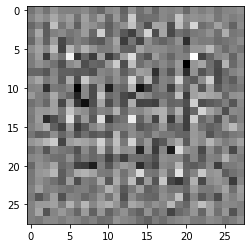

In [15]:
noise = tf.random.normal([1, 1, 1, noise_dim])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')


### Test discriminator network

* **CAUTION**: the outputs of discriminator is **logits** (unnormalized probability) NOT probabilities

In [16]:
decision = discriminator(generated_image)
print(decision)


tf.Tensor([[-3.9943487e-05]], shape=(1, 1), dtype=float32)


## 6. Define the loss functions and the optimizer

In [17]:
# use logits for consistency with previous code I made
# `tf.losses` and `tf.keras.losses` are the same API (alias)
bce = tf.losses.BinaryCrossentropy(from_logits=True)
mse = tf.losses.MeanSquaredError()


In [18]:
def WGANLoss(logits, is_real=True):
  """Computes Wasserstain GAN loss

  Args:
    logits (`2-rank Tensor`): logits
    is_real (`bool`): boolean, Treu means `-` sign, False means `+` sign.

  Returns:
    loss (`0-rank Tensor`): the WGAN loss value.
  """
  loss = tf.reduce_mean(logits)
  if is_real:
    loss = -loss

  return loss


In [19]:
def discriminator_loss(real_logits, fake_logits):
  # losses of real with label "1"
  real_loss = WGANLoss(logits=real_logits, is_real=True)
  # losses of fake with label "0"
  fake_loss = WGANLoss(logits=fake_logits, is_real=False)
  
  return real_loss + fake_loss


In [20]:
def generator_loss(fake_logits):
  # losses of Generator with label "1" that used to fool the Discriminator
  return WGANLoss(logits=fake_logits, is_real=True)


In [21]:
discriminator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_D)
generator_optimizer = tf.keras.optimizers.RMSprop(learning_rate_G)


## 7. Training

In [22]:
# keeping the random vector constant for generation (prediction) so
# it will be easier to see the improvement of the gan.
# To visualize progress in the animated GIF
const_random_vector_for_saving = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                   minval=-1.0, maxval=1.0)

### Define training one step function

In [23]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def discriminator_train_step(images):
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_logits = discriminator(images, training=True)
    fake_logits = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_logits)
    disc_loss = discriminator_loss(real_logits, fake_logits)    

  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
  
  # clip the weights for discriminator to implement 1-Lipshitz function
  #for var in discriminator.trainable_variables:
  #  var.assign(tf.clip_by_value(var, -0.01, 0.01))
    
  return gen_loss, disc_loss


In [24]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def generator_train_step():
  # generating noise from a uniform distribution
  noise = tf.random.uniform([batch_size, 1, 1, noise_dim], minval=-1.0, maxval=1.0)

  with tf.GradientTape() as gen_tape:
    generated_images = generator(noise, training=True)

    fake_logits = discriminator(generated_images, training=True)
    gen_loss = generator_loss(fake_logits)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    

### Train full steps

Epochs: 20.23 global_step: 15800 Wasserstein distance: 0.245 loss_G: -6.12 (14729.78 examples/sec; 0.004 sec/batch)


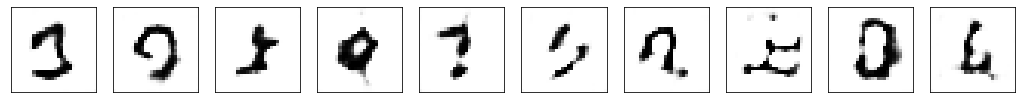

In [ ]:
print('Start Training.')
num_batches_per_epoch = int(N / batch_size)
global_step = tf.Variable(0, trainable=False)
num_learning_critic = 0

for epoch in range(1000000):

  for step, images in enumerate(train_dataset):
    start_time = time.time()
    
    if num_learning_critic < k:
      gen_loss, disc_loss = discriminator_train_step(images)
      num_learning_critic += 1
      global_step.assign_add(1)
    else:
      generator_train_step()
      num_learning_critic = 0
    
    if global_step.numpy() % print_steps == 0:
      epochs = epoch + step / float(num_batches_per_epoch)
      duration = max(time.time() - start_time, 1e-5)
      examples_per_sec = batch_size / float(duration)
      display.clear_output(wait=True)
      print("Epochs: {:.2f} global_step: {} Wasserstein distance: {:.3g} loss_G: {:.3g} ({:.2f} examples/sec; {:.3f} sec/batch)".format(
                epochs, global_step.numpy(), -disc_loss, gen_loss, examples_per_sec, duration))
      random_vector_for_sampling = tf.random.uniform([num_examples_to_generate, 1, 1, noise_dim],
                                                     minval=-1.0, maxval=1.0)
      sample_images = generator(random_vector_for_sampling, training=False)
      plt.figure(figsize=[18, 3])
      for j in range(10):
          plt.subplot(1, 10, j+1)
          plt.imshow(sample_images[j, :, :, 0], cmap='binary')
          plt.xticks([])
          plt.yticks([])
      plt.show()     
            
print('Training Done.')